<a href="https://colab.research.google.com/github/israelklink/Financas_Descentralizadas_Python/blob/main/Impermanent_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

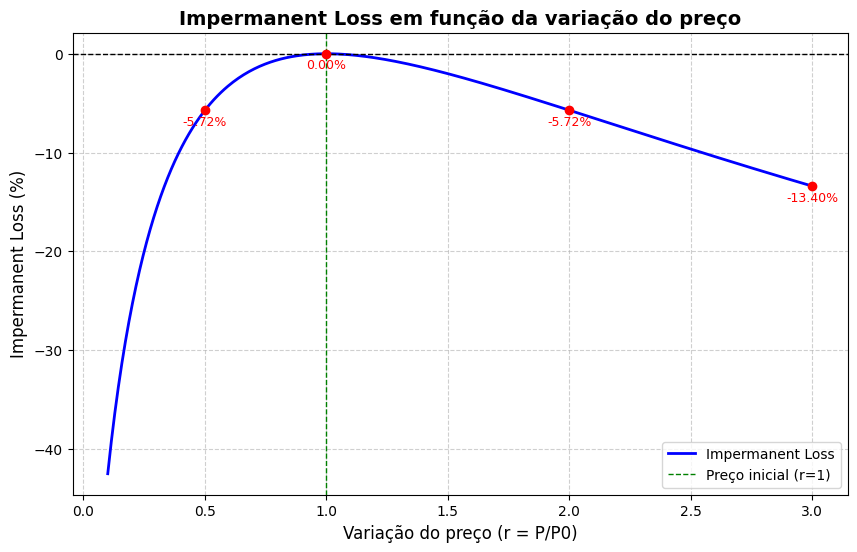

In [2]:
#Univ2

# Função para calcular o IL (padrão: pool 50/50)
def impermanent_loss(r):
    return (2 * np.sqrt(r) / (1 + r)) - 1

# Geração de valores de razão de preço (r = P/P0)
r_values = np.linspace(0.1, 3, 400)  # mais pontos para suavizar a curva
il_values = impermanent_loss(r_values)

# Pontos de interesse
pontos = [0.5, 1, 2, 3]
il_pontos = impermanent_loss(np.array(pontos)) * 100

# Plot
plt.figure(figsize=(10,6))
plt.plot(r_values, il_values * 100, label="Impermanent Loss", color="blue", linewidth=2)

# Destaque dos pontos importantes
plt.scatter(pontos, il_pontos, color="red", zorder=5)
for x, y in zip(pontos, il_pontos):
    plt.text(x, y - 1.5, f"{y:.2f}%", ha="center", fontsize=9, color="red")

# Linhas auxiliares
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(1, color='green', linestyle='--', linewidth=1, label="Preço inicial (r=1)")

# Estilo do gráfico
plt.title("Impermanent Loss em função da variação do preço", fontsize=14, fontweight="bold")
plt.xlabel("Variação do preço (r = P/P0)", fontsize=12)
plt.ylabel("Impermanent Loss (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


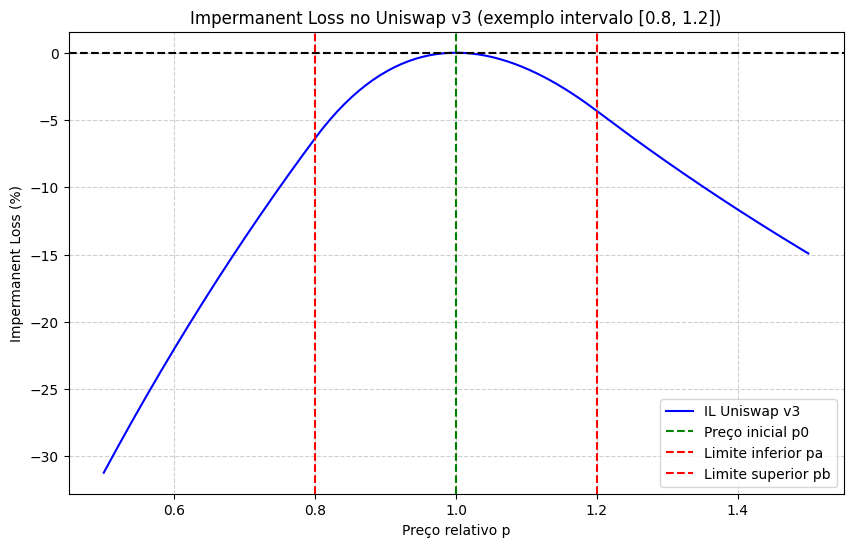

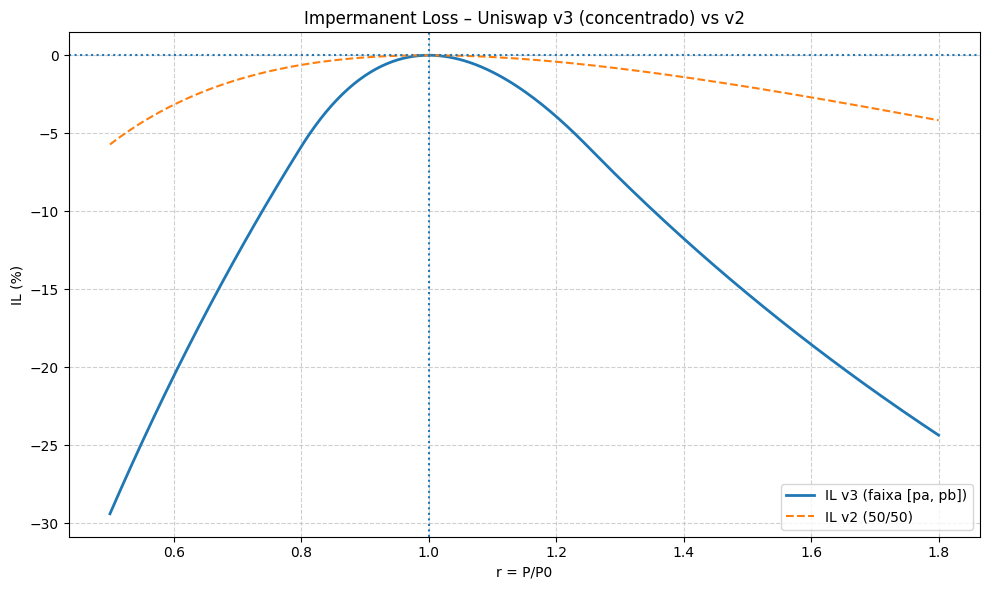

In [3]:


# Funções para Uniswap v3
def amounts_given_liquidity(L, pa, pb, p):
    """
    Retorna as quantidades de token0 (x) e token1 (y) para uma liquidez L
    no intervalo [pa, pb] no preço p.
    """
    if p <= pa:  # todo em token0
        x = L * (1/np.sqrt(pa) - 1/np.sqrt(pb))
        y = 0
    elif p >= pb:  # todo em token1
        x = 0
        y = L * (np.sqrt(pb) - np.sqrt(pa))
    else:  # dentro do range
        x = L * (1/np.sqrt(p) - 1/np.sqrt(pb))
        y = L * (np.sqrt(p) - np.sqrt(pa))
    return x, y

# Função para calcular Impermanent Loss no Uniswap v3
def impermanent_loss_v3(pa, pb, p0, p):
    L = 1.0  # normalização
    # valores iniciais (HODL)
    x0, y0 = amounts_given_liquidity(L, pa, pb, p0)
    V_hodl = x0 * p + y0

    # valores LP em p
    x, y = amounts_given_liquidity(L, pa, pb, p)
    V_lp = x * p + y

    return V_lp / V_hodl - 1

# Parâmetros
a, b, p0 = 0.8, 1.2, 1.0  # intervalo e preço inicial
p_values = np.linspace(0.5, 1.5, 200)
il_values = [impermanent_loss_v3(a, b, p0, p) * 100 for p in p_values]

# Plot
plt.figure(figsize=(10,6))
plt.plot(p_values, il_values, label="IL Uniswap v3", color="blue")
plt.axhline(0, color='black', linestyle='--')
plt.axvline(1, color='green', linestyle='--', label="Preço inicial p0")
plt.axvline(a, color='red', linestyle='--', label="Limite inferior pa")
plt.axvline(b, color='red', linestyle='--', label="Limite superior pb")

plt.title("Impermanent Loss no Uniswap v3 (exemplo intervalo [0.8, 1.2])")
plt.xlabel("Preço relativo p")
plt.ylabel("Impermanent Loss (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ==== Uniswap v3: IL para posição com liquidez concentrada ====
# Convenção: preço P = token1 por token0 (mesma de v2). Use preços em unidades "naturais" (sem X96).
# Intervalo de liquidez [pa, pb], preço inicial p0, preço final p.
# Fórmulas clássicas do Uniswap v3 (em termos de raiz do preço S = sqrt(P)):
# Se S <= SA:  amount0 = L * (SB - SA) / (SB * SA),   amount1 = 0
# Se SA < S < SB: amount0 = L * (SB - S)/(S * SB),    amount1 = L * (S - SA)
# Se S >= SB: amount0 = 0,                             amount1 = L * (SB - SA)

import numpy as np
import matplotlib.pyplot as plt

# --- helpers ---
def amounts_from_L(p, pa, pb, L=1.0):
    """Retorna (amount0, amount1) para uma posição com liquidez L no preço p, intervalo [pa, pb]."""
    S, SA, SB = np.sqrt(p), np.sqrt(pa), np.sqrt(pb)
    if S <= SA:  # todo em token0
        amt0 = L * (SB - SA) / (SB * SA)
        amt1 = 0.0
    elif S < SB:  # faixa ativa (misto)
        amt0 = L * (SB - S) / (S * SB)
        amt1 = L * (S - SA)
    else:  # todo em token1
        amt0 = 0.0
        amt1 = L * (SB - SA)
    return amt0, amt1

def value_in_token1(amount0, amount1, p):
    return amount0 * p + amount1

# --- IL v3 ---
def impermanent_loss_v3(p, p0, pa, pb, L=1.0):
    """Calcula IL = V_LP(p)/V_HODL(p) - 1 para uma posição v3 com intervalo [pa, pb].
    1) Calcula amounts no p0 (com L) -> esses são os ativos iniciais do LP
    2) HODL: mantém esses amounts até p e avalia
    3) LP: valor da posição com a MESMA L no preço p
    """
    # ativos iniciais (no p0)
    a0, b0 = amounts_from_L(p0, pa, pb, L=L)
    V_hodl_p = value_in_token1(a0, b0, p)
    # valor LP no p
    a1, b1 = amounts_from_L(p, pa, pb, L=L)
    V_lp_p = value_in_token1(a1, b1, p)
    return (V_lp_p / V_hodl_p) - 1.0

# --- Exemplo e gráfico ---
p0 = 1.0
pa, pb = 0.8, 1.25   # intervalo de liquidez (20% abaixo e 25% acima do preço inicial)

r_values = np.linspace(0.5, 1.8, 300)  # variação de preço P/P0
p_values = p0 * r_values
il_v3 = np.array([impermanent_loss_v3(p, p0, pa, pb, L=1.0) for p in p_values]) * 100

# Para comparação, IL 50/50 v2 (perpétuo)
def il_v2(r):
    return (2 * np.sqrt(r) / (1 + r)) - 1
il_v2_vals = il_v2(r_values) * 100

plt.figure(figsize=(10,6))
plt.plot(r_values, il_v3, label="IL v3 (faixa [pa, pb])", linewidth=2)
plt.plot(r_values, il_v2_vals, linestyle='--', label="IL v2 (50/50)")
plt.axhline(0, linestyle=':')
plt.axvline(1.0, linestyle=':')
plt.title("Impermanent Loss – Uniswap v3 (concentrado) vs v2")
plt.xlabel("r = P/P0")
plt.ylabel("IL (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Dica: altere (pa, pb) para ver como o intervalo afeta o IL.
# Quando o preço sai da faixa (p <= pa ou p >= pb), a posição vira 100% token0 ou 100% token1.
